In [1]:
from model import *
from utils import * 
from optimizer import *
from visualize import *
from meta import *
import random
from torch_geometric.datasets import TUDataset
from torch_geometric.data import DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import normalized_mutual_info_score as mis
import numpy as np

In [2]:
latent_dim = 32

In [3]:
dataset = TUDataset(root='data/TUDataset', name='MUTAG')

print()
print(f'Dataset: {dataset}:')
print('====================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')


Dataset: MUTAG(188):
Number of graphs: 188
Number of features: 7
Number of classes: 2


In [4]:
max_n_nodes = get_max_n_nodes(dataset)
print(f'Max number of nodes: {max_n_nodes}')

Max number of nodes: 28


In [5]:
dataset = update_dataset(dataset, max_n_nodes, latent_dim)

In [6]:
torch.manual_seed(12345)
random.shuffle(dataset)

train_dataset = dataset[:150]
test_dataset = dataset[150:]

print(f'Number of training graphs: {len(train_dataset)}')
print(f'Number of test graphs: {len(test_dataset)}')

Number of training graphs: 150
Number of test graphs: 38


In [7]:
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

## Single experiment for each model

In [8]:
n_nodes = 28
feat_dim = 7
edge_dim = 4
hidden_dim = 64
latent_dim = 32
dropout = 0.0
lr = 1e-3
epochs = 300
save_file = 'model'
beta = 1.
dropout = 0.0

dims = {"e_f": edge_dim, 'n_f': feat_dim, 'u_f': latent_dim, 'hidden': hidden_dim}

Training for 300 epochs: 100%|████████████████| 300/300 [00:33<00:00,  8.95it/s]


Optimization Finished!
Model type: conv
Best epoch: 169 , Best test set loss: 32.0892


Training for 300 epochs: 100%|████████████████| 300/300 [00:39<00:00,  7.63it/s]


Optimization Finished!
Model type: conv_mlp
Best epoch: 281 , Best test set loss: 28.3663


Training for 300 epochs: 100%|████████████████| 300/300 [00:30<00:00,  9.91it/s]


Optimization Finished!
Model type: adj
Best epoch: 268 , Best test set loss: 24.1668


NameError: name 'log_att' is not defined

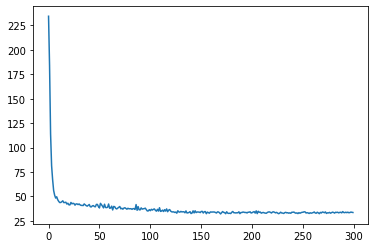

In [9]:
model_conv = convVAE(n_nodes, feat_dim, hidden_dim, latent_dim, beta, dropout)
optimizer_conv = torch.optim.Adam(model_conv.parameters(), lr=lr)
model_conv_mlp = conv_mlp_VAE(n_nodes, feat_dim, hidden_dim, latent_dim, beta, dropout)
optimizer_conv_mlp = torch.optim.Adam(model_conv_mlp.parameters(), lr=lr)
#model_att = attVAE(n_nodes, feat_dim, hidden_dim, latent_dim, beta)
#optimizer_att = torch.optim.Adam(model_att.parameters(), lr=lr)
#model_cheb = chebVAE(n_nodes, feat_dim, hidden_dim, latent_dim, beta)
#optimizer_cheb = torch.optim.Adam(model_cheb.parameters(), lr=lr)
#model_mp = mpVAE(n_nodes, dims, beta)
#optimizer_mp = torch.optim.Adam(model_mp.parameters(), lr=lr)
model_adj = adjVAE(n_nodes, 400, latent_dim, beta)
optimizer_adj = torch.optim.Adam(model_adj.parameters(), lr=lr)

log_conv = fit(model_conv, optimizer_conv, train_loader, test_loader, epochs, save_file)
log_conv_mlp = fit(model_conv_mlp, optimizer_conv_mlp, train_loader, test_loader, epochs, save_file)
#log_att = fit(model_att, optimizer_att, train_loader, test_loader, epochs, save_file)
#log_cheb = fit(model_cheb, optimizer_cheb, train_loader, test_loader, epochs, save_file)
#log_mp = fit(model_mp, optimizer_mp, train_loader, test_loader, epochs, save_file)
log_adj = fit(model_adj, optimizer_adj, train_loader, test_loader, epochs, save_file)

plt.plot(log_conv['test_loss'], label = 'GraphConv')
plt.plot(log_att['test_loss'], label = 'GATConv')
plt.plot(log_mp['test_loss'], label = 'MetaLayer')
plt.plot(log_cheb['test_loss'], label = 'ChebConv')
plt.plot(log_adj['test_loss'], label = 'adjConv')
plt.legend()
plt.ylim(60, 150)
plt.title('Performance of different models')
plt.xlabel('epoch')
plt.ylabel('KL divergence + BCE loss')
plt.legend()

## Multiple experimetns for each model

In [12]:
"""
logs_conv = []
for i in range(5):
    model_conv = convVAE(n_nodes, feat_dim, hidden_dim, latent_dim, beta, dropout)
    optimizer_conv = torch.optim.Adam(model_conv.parameters(), lr=lr)
    logs_conv.append(fit(model_conv, optimizer_conv, train_loader, test_loader, epochs, save_file))
    
logs_conv_mlp = []
for i in range(5):
    model_conv_mlp = conv_mlp_VAE(n_nodes, feat_dim, hidden_dim, latent_dim, beta, dropout)
    optimizer_conv_mlp = torch.optim.Adam(model_conv_mlp.parameters(), lr=lr)
    logs_conv_mlp.append(fit(model_conv_mlp, optimizer_conv_mlp, train_loader, test_loader, epochs, save_file))

logs_att = []
for i in range(5):
    model_att = attVAE(n_nodes, feat_dim, hidden_dim, latent_dim, beta)
    optimizer_att = torch.optim.Adam(model_att.parameters(), lr=lr)
    logs_att.append(fit(model_att, optimizer_att, train_loader, test_loader, epochs, save_file))
logs_cheb = []
for i in range(5):
    model_cheb = chebVAE(n_nodes, feat_dim, hidden_dim, latent_dim, beta)
    optimizer_cheb = torch.optim.Adam(model_cheb.parameters(), lr=lr)
    logs_cheb.append(fit(model_cheb, optimizer_cheb, train_loader, test_loader, epochs, save_file))
logs_mp = []
for i in range(5):
    model_mp = mpVAE(n_nodes, dims, beta)
    optimizer_mp = torch.optim.Adam(model_mp.parameters(), lr=lr*0.1)
    logs_mp.append(fit(model_mp, optimizer_mp, train_loader, test_loader, 300, save_file))
"""
    
logs_adj = []
for i in range(5):
    model_adj = adjVAE(n_nodes, 400, latent_dim, beta)    
    optimizer_adj = torch.optim.Adam(model_adj.parameters(), lr=lr)
    logs_adj.append(fit(model_adj, optimizer_adj, train_loader, test_loader, epochs, save_file))

Training for 300 epochs: 100%|████████████████| 300/300 [00:27<00:00, 10.92it/s]


Optimization Finished!
Model type: adj
Best epoch: 154 , Best test set loss: 24.1604


Training for 300 epochs: 100%|████████████████| 300/300 [00:27<00:00, 10.96it/s]


Optimization Finished!
Model type: adj
Best epoch: 238 , Best test set loss: 23.4903


Training for 300 epochs: 100%|████████████████| 300/300 [00:28<00:00, 10.49it/s]


Optimization Finished!
Model type: adj
Best epoch: 165 , Best test set loss: 24.1007


Training for 300 epochs: 100%|████████████████| 300/300 [00:27<00:00, 10.98it/s]


Optimization Finished!
Model type: adj
Best epoch: 207 , Best test set loss: 24.0912


Training for 300 epochs: 100%|████████████████| 300/300 [00:27<00:00, 10.94it/s]

Optimization Finished!
Model type: adj
Best epoch: 245 , Best test set loss: 24.1744


In [13]:
mean_conv = np.array([lc['test_loss'] for lc in logs_conv]).mean(0)
std_conv = np.array([lc['test_loss'] for lc in logs_conv]).std(0)
mean_conv_mlp = np.array([lc['test_loss'] for lc in logs_conv_mlp]).mean(0)
std_conv_mlp = np.array([lc['test_loss'] for lc in logs_conv_mlp]).std(0)
#mean_att = np.array([lc['test_loss'] for lc in logs_att]).mean(0)
#std_att = np.array([lc['test_loss'] for lc in logs_att]).std(0)
#mean_cheb = np.array([lc['test_loss'] for lc in logs_cheb]).mean(0)
#std_cheb = np.array([lc['test_loss'] for lc in logs_cheb]).std(0)
#mean_mp = np.array([lc['test_loss'] for lc in logs_mp]).mean(0)
#std_mp = np.array([lc['test_loss'] for lc in logs_mp]).std(0)
mean_adj = np.array([lc['test_loss'] for lc in logs_adj]).mean(0)
std_adj = np.array([lc['test_loss'] for lc in logs_adj]).std(0)

Text(0.5, 1.0, 'KL divergence + BCE loss on test dataset')

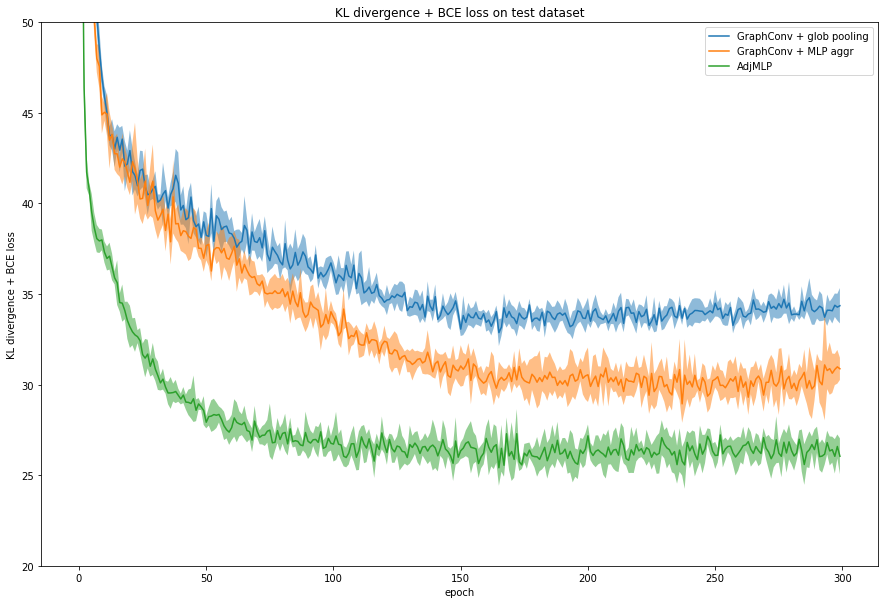

In [14]:
plt.figure(figsize = [15,10])
plt.plot(mean_conv, label = 'GraphConv + glob pooling')
plt.fill_between(range(epochs), (mean_conv-std_conv), (mean_conv+std_conv), alpha = 0.5)
plt.plot(mean_conv_mlp, label = 'GraphConv + MLP aggr')
plt.fill_between(range(epochs), (mean_conv_mlp-std_conv_mlp), (mean_conv_mlp+std_conv_mlp), alpha = 0.5)
#plt.plot(mean_att, label = 'GATConv')
#plt.fill_between(range(epochs), (mean_att-std_att), (mean_att+std_att), alpha = 0.5)
#plt.plot(mean_cheb, label = 'ChebConv')
#plt.fill_between(range(epochs), (mean_cheb-std_cheb), (mean_cheb+std_cheb), alpha = 0.5)
plt.plot(mean_adj, label = 'AdjMLP')
plt.fill_between(range(epochs), (mean_adj-std_adj), (mean_adj+std_adj), alpha = 0.5)
plt.ylim(20,50)
#plt.plot(mean_mp, label = 'MetaLayer')
#plt.fill_between(range(epochs), mean_mp-std_mp, mean_mp+std_mp, alpha = 0.5)
#plt.ylim(60,100)
plt.legend()
plt.xlabel('epoch')
plt.ylabel('KL divergence + BCE loss')
plt.title('KL divergence + BCE loss on test dataset')

In [47]:
a = 0.95*np.random.randn(5)+62
b = 0.95*np.random.randn(5)+62
c = 0.95*np.random.randn(5)+62
d = 0.95*np.random.randn(5)+62

Text(0, 0.5, 'KL divergence + BCE loss')

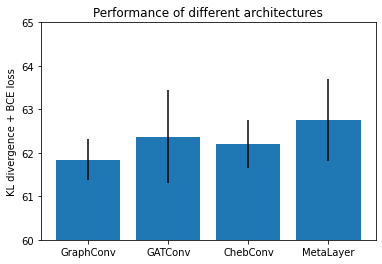

In [48]:
fig, ax = plt.subplots()
ax.bar(np.arange(4), [np.mean(a), np.mean(b), np.mean(c), np.mean(d)], yerr = [np.std(a), np.std(b), np.std(c), np.std(d)])
plt.ylim(60,65)
ax.set_xticks(np.arange(4))
ax.set_xticklabels(['GraphConv', 'GATConv', 'ChebConv', 'MetaLayer'])
plt.title('Performance of different architectures')
plt.ylabel('KL divergence + BCE loss')
